# 距离测定

## 数据读取

In [5]:
import nd2reader
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
import plotly.graph_objs as go

In [6]:
filename = "./20220329barcode band3.nd2"
npname = "band3_488.npy"
channel = 0 # ['488TIRF', '640TIRF']

In [7]:
imgset = nd2reader.Nd2(filename)

In [8]:
imgset.channels

['488TIRF', '640TIRF']

In [9]:
fov_range =imgset.fields_of_view

In [10]:
# 混合高斯拟合的回调函数
def gaussian2D(meshgrid,offset, amplitude, xo, yo, sigma):
    x, y = meshgrid
    xo = float(xo)
    yo = float(yo)
    g = offset+amplitude*np.exp(((x-xo)**2+(y-yo)**2)/((sigma**2)*-2))/(2*np.pi*(sigma**2))
    return g.ravel()

def gaussian2D2(meshgrid, offset, a1, xo1, yo1, s1, a2, xo2, yo2, s2):
    g = gaussian2D(meshgrid, offset,a1, xo1, yo1, s1)+gaussian2D(meshgrid, offset,a2, xo2, yo2, s2 )
    return g

def gaussian2D3(meshgrid, offset, a1, xo1, yo1,s1, a2, xo2, yo2, s2, a3, xo3, yo3, s3):
    g = gaussian2D(meshgrid, offset,a1, xo1, yo1, s1, )+gaussian2D(meshgrid, offset,a2, xo2, yo2, s2, )+gaussian2D(meshgrid,offset, a3, xo3, yo3, s3, )
    return g

def gaussian2D4(meshgrid, offset, a1, xo1, yo1, s1, a2, xo2, yo2, s2, a3, xo3, yo3, s3, a4, xo4, yo4, s4):
    g = gaussian2D(meshgrid,offset, a1, xo1, yo1, s1, )+gaussian2D(meshgrid,offset, a2, xo2, yo2, s2, )+gaussian2D(meshgrid,offset, a3, xo3, yo3, s3, )+gaussian2D(meshgrid, offset,a4, xo4, yo4, s4, )
    return g

In [11]:
def crop_cnt(raw, cnt_i, contours):
    mask = np.zeros_like(raw)
    cv2.drawContours(mask, contours, cnt_i, (1.0), -1)
    
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask, kernel)
    mask = cv2.dilate(mask, kernel)
    x, y, w, h = cv2.boundingRect(contours[cnt_i])
    y0 = max(y-3, 0)
    y1 = min(y+h+3, imgset.height)
    x0 = max(x-3, 0)
    x1 = min(x+w+3, imgset.width)
    tmp_img = raw[y0:y1, x0:x1]*mask[y0:y1, x0:x1]
    # plt.imshow(tmp_img)
    return tmp_img, x0, y0,x1-x0,y1-y0

In [37]:
def drawContour(img_masked, cnt, ratio=0.05):
    poly = cnt.transpose((1,0,2))
    # 轮廓误差
    epsilon = ratio*cv2.arcLength(cnt,True)
    cnapprox = cv2.approxPolyDP(cnt, epsilon, True)
    approx = cnapprox.transpose((1,0,2))
    if cv2.isContourConvex(cnapprox):
        # green circle for nearly convex contours
        img_masked = cv2.polylines(img_masked, poly, True, color=(0, 255, 0))
    else:
        # white circle unconvex contours and red circle for defects
        img_masked = cv2.polylines(img_masked, poly, True, color=(255, 255, 255))
        hull = cv2.convexHull(cnt, returnPoints=False)
        defects = cv2.convexityDefects(cnt,hull)
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            far = tuple(cnt[f][0])
            cv2.circle(img_masked,far,0,[255,0,255],-1)
    return img_masked, cv2.isContourConvex(cnapprox)

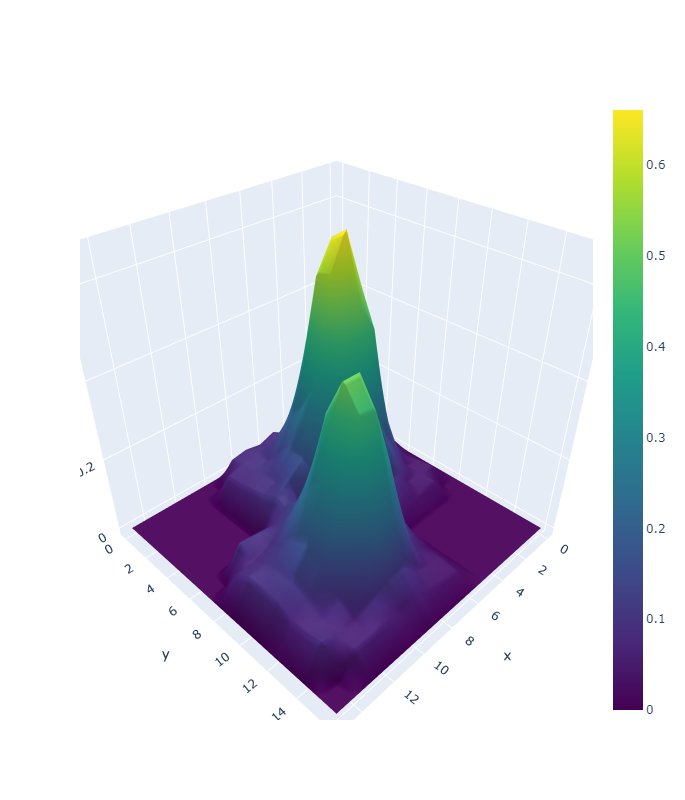

In [63]:
img = imgset.get_image(0, 0, channel, 0)
img = (img-img.min())/(img.max()-img.min())
# plt.figure(figsize=(50,50))
# plt.imshow(img[643:653,720:730])
# x, y = np.linspace(0, 1, 10), np.linspace(0, 1, 10)
# fig = go.Figure(data=[go.Surface(z=img[643:653,720:730], x=x, y=y,colorscale='Viridis')])
fig.update_layout(autosize=False,
    width=800,
    height=800,)
fig.show()

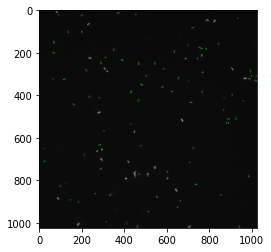

In [39]:
plt.imshow(img_colored)

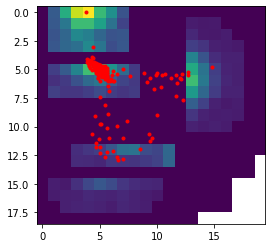

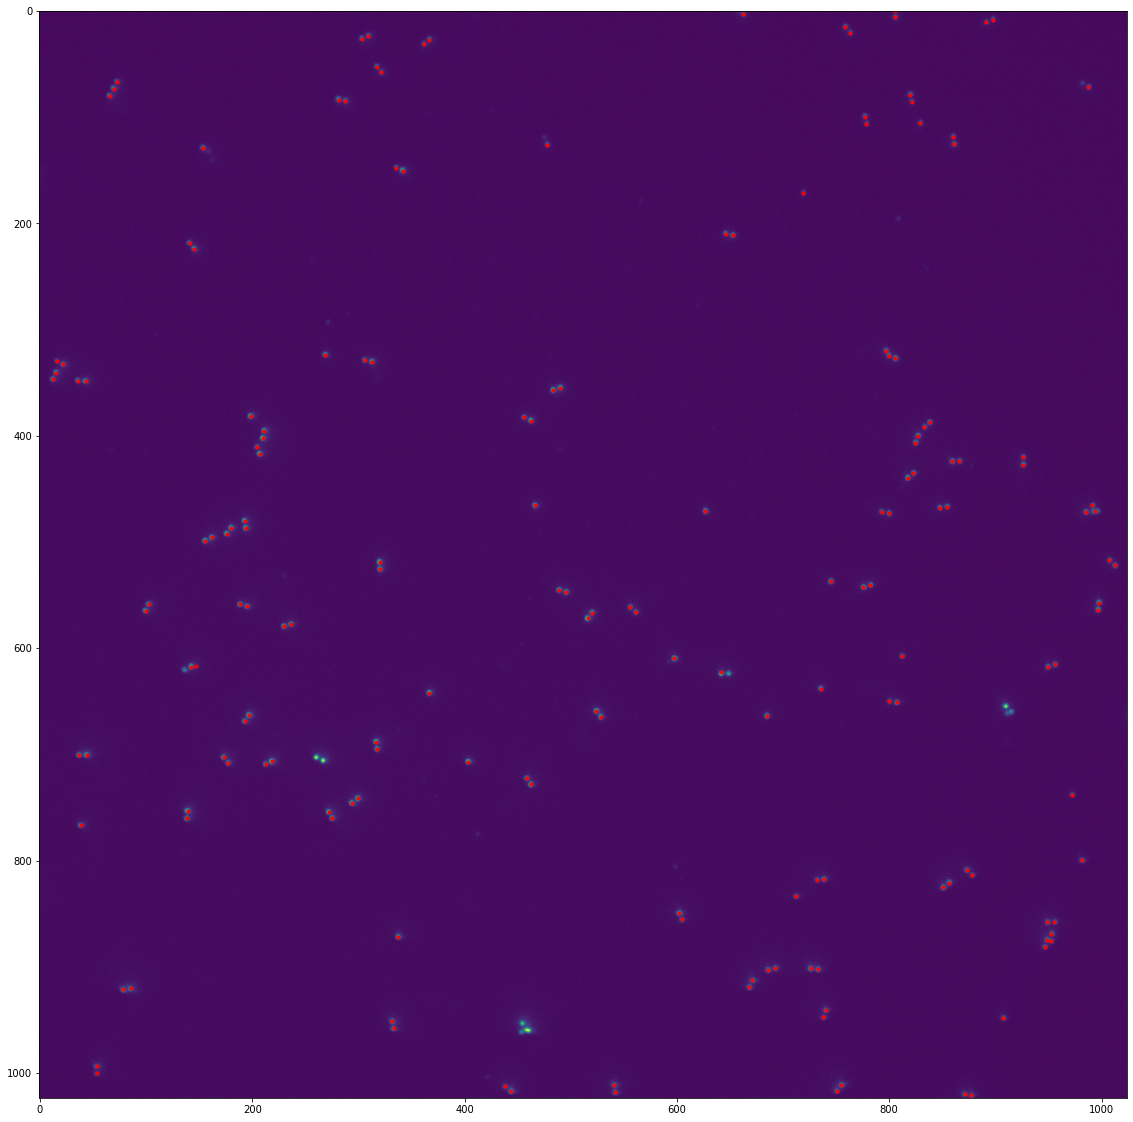

In [64]:
m_edges = []
from tqdm import tqdm
# for fov in tqdm(fov_range):
# for fov in fov_range:
for fov in range(1,2):
    # print(fov)
    img = imgset.get_image(0, 0, channel, fov)
    img = (img-img.min())/(img.max()-img.min())
    img_8 = (img*255).astype(np.uint8)

    bubble_threshold = 30

    r, mask = cv2.threshold(img_8, bubble_threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)

    mask = cv2.erode(mask, kernel)
    mask = cv2.dilate(mask, kernel)
    mask = cv2.erode(mask, kernel)
    mask = cv2.dilate(mask, kernel)
    mask = cv2.erode(mask, kernel)
    mask = cv2.dilate(mask, kernel)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    img_colored = cv2.cvtColor(img_8, cv2.COLOR_GRAY2RGB)
    
    areas = []
    convexities = []
    for i,cnt in enumerate(contours):
        # print(i)
        area = cv2.contourArea(cnt)
        areas.append(area)
        M = cv2.moments(cnt)
        cx= int(M['m10']/M['m00'])+10
        cy= int(M['m01']/M['m00'])+3
        img_colored, is_convex = drawContour(img_colored, cnt, 0.01)
        convexities.append(is_convex)
        # cv2.putText(img_colored, text= str(area), org=(cx,cy),
                # fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255),
                # thickness=1, lineType=cv2.LINE_AA)
    
    # plt.figure(figsize=(20,20))
    # plt.imshow(img_colored)
    # break
    
    hist_data = [areas]
    group_labels = ['area'] # name of the dataset
    gmm = GaussianMixture(n_components=2)
    gmm.fit(np.transpose(hist_data))
    

    min_ind = np.argmin(gmm.means_)
    max_ind = np.argmax(gmm.means_)

    min_mean = gmm.means_[min_ind][0]
    max_mean = gmm.means_[max_ind][0]
    stds = np.sqrt(gmm.covariances_).ravel() 
    min_std = stds[min_ind]
    max_std = stds[max_ind]
    # fig = ff.create_distplot(hist_data, group_labels,show_hist=False)
    # fig.add_shape(type="line",x0=min_mean,y0=0,x1=min_mean,y1=0.055,
    #               line=dict(
    #     color="LightSeaGreen",
    #     width=1,
    #     dash="dashdot",))
    # fig.add_shape(type="line",x0=max_mean,y0=0,x1=max_mean,y1=0.055,
    #               line=dict(
    #     color="Gray",
    #     width=1,
    #     dash="dashdot",))
    # fig.show()
    # break
    
    ## 判断峰值个数
    ## 1. 过滤数据，面积超过最大峰99%置信区间（$\gt \mu_{max} + 3\sigma_{max}$) 与低于最小峰95%（$\lt \mu_{min} - 3\sigma_{min}$) 的被滤除
    ## 2. 凸轮廓不是多点混杂
    ## 3. 非凸轮廓且非最小面积峰值（$\gt \mu_{min} + 2\sigma_{min}$) 被判定为两点混杂
    ## 4. 混杂的两点若距离过近，则合并为一个点

    point_xs = []
    point_ys = []
    for i in range(len(contours)):
    # for i in tqdm(range(42,43)):
        # 面积过大或过小（99%置信区间）被滤除
        if areas[i] < min_mean - 3 * min_std or areas[i] > max_mean + 3 * min_std:
            continue
        tmp_img, x0, y0,w,h = crop_cnt(img, i, contours)
        x = np.arange(tmp_img.shape[1])
        y = np.arange(tmp_img.shape[0])
        x, y = np.meshgrid(x,y)

        # TODO!!!
        initial_guess1 = (0,0.8, w/2, h/2,(w+h)/8)
        initial_guess2 = (0,0.4, w/2, h/2,(w+h)/8, 0.4, w/2, h/2,(w+h)/8)

        bounds1 = ([0,0,0,0,0],[np.inf, np.inf,w,h,w+h])
        bounds2 = ([0,0,0,0,0,0,0,0,0],[np.inf, np.inf,w,h,w+h,np.inf,w,h,w+h])
        # 凸轮廓或在最小面积峰值内则被判定为单点，适用于一重二维高斯分布
        if convexities[i] or areas[i] < min_mean + 2 * min_std:
            popt, pcov = curve_fit(gaussian2D, (x,y), tmp_img.ravel(), p0=initial_guess1, bounds=bounds1)
            point_xs.append(x0+popt[2])
            point_ys.append(y0+popt[3])
            plt.imshow(tmp_img)
            plt.plot([popt[2]], [popt[3]], '.', color='red')
        else:
            popt, pcov = curve_fit(gaussian2D2, (x,y), tmp_img.ravel(), p0=initial_guess2, bounds=bounds2)
            d = (popt[2]-popt[6])**2 + (popt[3]-popt[7]) **2
            if d < 9:
                m_x = (popt[2]+popt[6])/2
                m_y = (popt[3]+popt[7])/2
                point_xs.append(x0+m_x)
                point_ys.append(y0+m_y)
                plt.imshow(tmp_img)
                plt.plot([m_x], [m_y], '.', color='red')
            else:
                point_xs.append(x0+popt[2])
                point_ys.append(y0+popt[3])
                point_xs.append(x0+popt[6])
                point_ys.append(y0+popt[7])
                plt.imshow(tmp_img)
                plt.plot([popt[2],popt[6]], [popt[3],popt[7]], '.', color='red')
                # x, y = np.linspace(0, 1, 10), np.linspace(0, 1, 10)
                fig = go.Figure(data=[go.Surface(z=tmp_img, colorscale='Viridis')])

#     plt.figure(figsize=(20,20))
#     plt.imshow(img_colored)

    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.plot(point_xs, point_ys, '.', color='red')

    point_n = len(point_xs)
    edges = np.zeros((point_n, point_n))
    for i in range(point_n):
        for j in range(point_n):
            edges[i,j] = np.sqrt((point_xs[i]-point_xs[j])**2+(point_ys[i]-point_ys[j])**2)
        edges[i,i]=np.inf

    m_edge = edges.min(axis=0)
    m_edges = np.append(m_edges, m_edge)

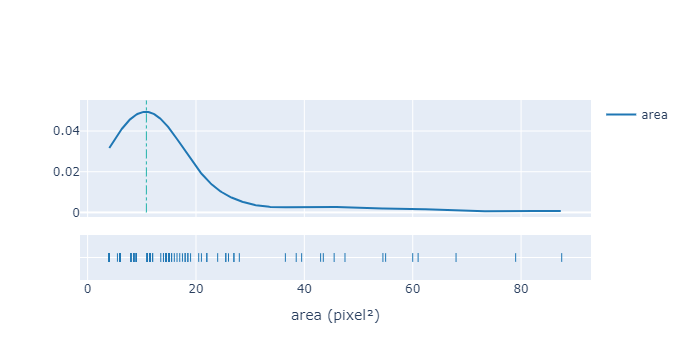

In [48]:
fig.update_xaxes(title="area (pixel²)")

In [251]:
pixel_microns = 0.07
nm_m_edges = m_edges * pixel_microns*1000

In [400]:
nm_m_edges = np.fromfile("band3_647.npy")
len(nm_m_edges)

3553

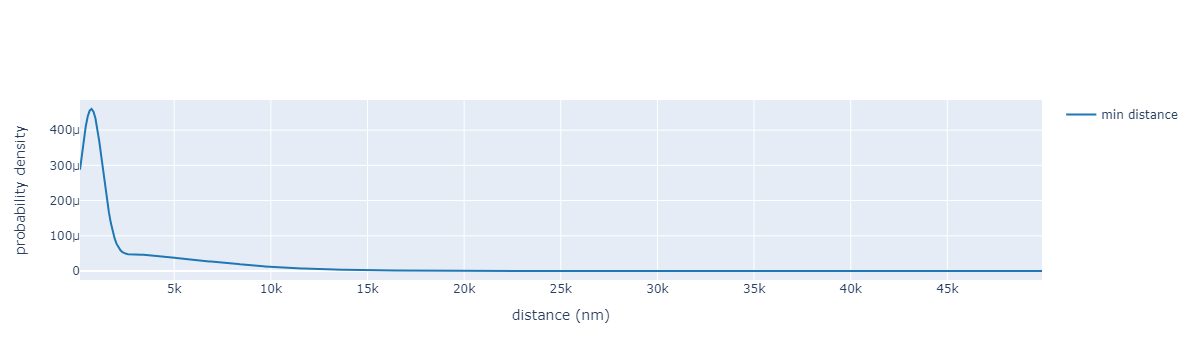

(583.0094112020714, 210.78359955406947)

In [390]:
gmm2 = GaussianMixture(n_components=4)
gmm2.fit(np.transpose([nm_m_edges]))
fig = ff.create_distplot([nm_m_edges],['min distance'],show_hist=False,show_rug=False)
min_ind = np.argmin(gmm2.means_)
# fig.add_shape(type="line",x0=gmm2.means_[min_ind][0],y0=0,x1=gmm2.means_[min_ind][0],y1=0.001)
fig.update_xaxes(title="distance (nm)")
fig.update_yaxes(title="probability density")
fig.show()
std = np.sqrt(gmm2.covariances_[min_ind][0][0])
m = gmm2.means_[min_ind][0]
m,std

In [391]:
# 99% 置信区间
m_edges_filtered = nm_m_edges[nm_m_edges < m+3*std]
m_edges_filtered = m_edges_filtered[m_edges_filtered> m - 3*std]
m_edges_filtered.std() / m_edges_filtered.mean()

0.18668116125560646

In [392]:
gmm3 = GaussianMixture(n_components=4)
gmm3.fit(np.transpose([m_edges_filtered]))

GaussianMixture(n_components=4)

In [393]:
gmm3.weights_, gmm3.covariances_, gmm3.means_

(array([0.03085077, 0.73326051, 0.05927469, 0.17661404]),
 array([[[8940.22381851]],
 
        [[ 281.14150919]],
 
        [[4697.91257189]],
 
        [[7424.36983608]]]),
 array([[1016.90231485],
        [ 730.38233368],
        [ 284.69369369],
        [ 632.39221602]]))

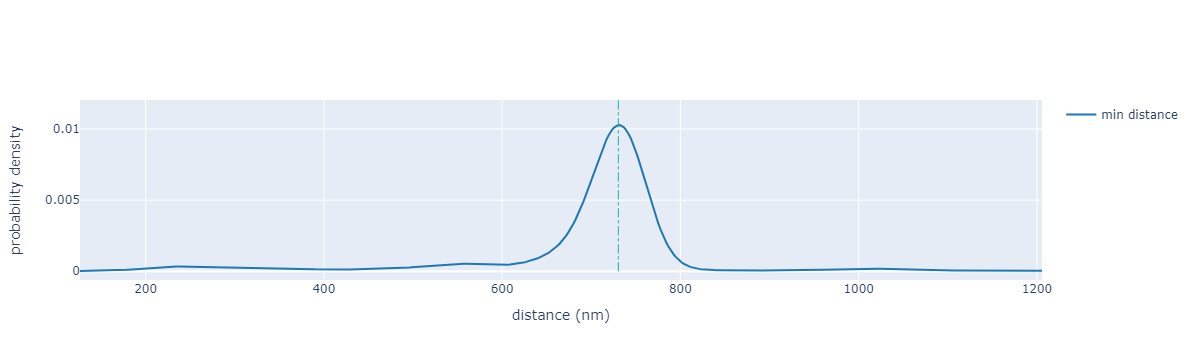

In [396]:
fig = ff.create_distplot([m_edges_filtered],['min distance'],show_hist=False,show_rug=False)
fig.update_xaxes(title="distance (nm)")
fig.update_yaxes(title="probability density")
fig.add_shape(type="line",x0=gmm3.means_[1][0],y0=0,x1=gmm3.means_[1][0],y1=0.012,
             line=dict(
        color="LightSeaGreen",
        width=1,
        dash="dashdot",
    ))
fig.show()

In [388]:
 np.sqrt(gmm3.covariances_[0][0][0]) / gmm3.means_[0][0]

0.020021353411292905

In [261]:
# nm_m_edges.tofile(npname)

In [123]:
nm_m_edges

array([ 487.15053422,  462.16303012,  487.15053422, ...,  491.98873237,
        491.98873237, 9087.56787061])

In [296]:
13.38715958798749/ np.sqrt(len(m_edges_filtered))

0.22503401007236012

In [349]:
129.836 / 695.497

0.18668089150636166

In [340]:
19.167 / 457.403

0.04190396652404991

In [341]:
5.705 / 465.100 

0.01226617931627607

In [364]:
len(nm_m_edges)

6001

In [365]:
16.753 / 730.391

0.022937029618382485

In [404]:
41.680 / np.sqrt(3220)

0.7345134866779515